<a href="https://colab.research.google.com/github/erikroruiz/OCT_style_transfer/blob/main/images_prep_pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Comprobar el entorno RAM

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


### Comprobar el entorno GPU

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
import numpy as np
import cv2 
import os
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import drive

In [ ]:
#Creamos la carpeta origen de Google Drive
BASE_FOLDER = '/content/drive/My Drive/TFM/'
# Montamos la carpeta en Google drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Definición de variables

In [ ]:
  rel_test_path = BASE_FOLDER+'datasets/images_oct/train' # Ubicación de las imágenes de training
  N_images = 17 # 34 = 28 de train + 6 de test
  train_imgs = 14
  test_imgs = 3 
  N_recortes = 3000
  # Recorte imagen inicial
  h_rec = 300 # altura de la imagen recortada
  w_rec = 900 # anchura de la imagen recortada
  stride = 100 # paso
  top_rec = 0
  # recortes
  h_r = 300
  w_r = 300

### Funciones


In [ ]:
# Recorrer una imagen y sacar recortes con un stepsize definido
def sliding_window(image, stepSize, windowSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]]) # yield devuelve una función generadora

def get_cropped_img (img, h_rec, w_rec, h_ini):
    h, w = img.shape
    # Si la imagen no coincide ni en altura ni en anchura
    if (img.shape[0] != h_rec and img.shape[1] != w_rec):
        padding_inicio = int((h - h_rec))
        padding_fin = int((w - w_rec)/2)
        # Recortamos la imagen centrada en verticalmente y recortada por abajo
        img = img[h_ini:-(padding_inicio-h_ini),padding_fin:-padding_fin]
    # Si la imagen tiene la misma altura
    if (img.shape[0] == h_rec and img.shape[1] != w_rec):
        padding_fin = int((w - w_rec)/2)
        img = img[:,padding_fin:-padding_fin]
    # Si la imagen tiene la misma anchura
    if (img.shape[0] != h_rec and img.shape[1] == w_rec):
        padding_inicio = int((h - h_rec))
        img = img[h_ini:-(padding_inicio-h_ini),:]
    return img

# Guardar array en disco en formato npy
def guardar_array (url_nombre, array):
    np.save(url_nombre, array)

### Cargamos los nombres de las imagenes que se van a recortar, tanto limpias como con ruido

In [ ]:
# Cargamos los nombres de las imagenes que se van a recortar    
clear_names = [] # Imágenes con ruido para test
noise_names = [] # Imágenes con ruido para test

for id in range(0,N_images):
    clear_names.append(rel_test_path+"/%0.2d_01.tif" % (id+1))
    noise_names.append(rel_test_path+"/%0.2d_02.tif" % (id+1))

print ("Nombres de las imágenes SIN ruido:",type(clear_names), len(clear_names))
print (clear_names)
print ("Nombres de las imágenes CON ruido:",type(noise_names), len(noise_names))
print (noise_names)

Nombres de las imágenes SIN ruido: <class 'list'> 17
['/content/drive/My Drive/TFM/datasets/images_oct/train/01_01.tif', '/content/drive/My Drive/TFM/datasets/images_oct/train/02_01.tif', '/content/drive/My Drive/TFM/datasets/images_oct/train/03_01.tif', '/content/drive/My Drive/TFM/datasets/images_oct/train/04_01.tif', '/content/drive/My Drive/TFM/datasets/images_oct/train/05_01.tif', '/content/drive/My Drive/TFM/datasets/images_oct/train/06_01.tif', '/content/drive/My Drive/TFM/datasets/images_oct/train/07_01.tif', '/content/drive/My Drive/TFM/datasets/images_oct/train/08_01.tif', '/content/drive/My Drive/TFM/datasets/images_oct/train/09_01.tif', '/content/drive/My Drive/TFM/datasets/images_oct/train/10_01.tif', '/content/drive/My Drive/TFM/datasets/images_oct/train/11_01.tif', '/content/drive/My Drive/TFM/datasets/images_oct/train/12_01.tif', '/content/drive/My Drive/TFM/datasets/images_oct/train/13_01.tif', '/content/drive/My Drive/TFM/datasets/images_oct/train/14_01.tif', '/conten

### Inicializamos los arrays donde vamos a guardar los recortes como tipo entero

In [ ]:

# Importante: inicializamos los arrays que donde vamos a guardar los recortes como tipo entero
print("===> Inicializando los arrays de recortes ...")
clear_array_train = np.int8(np.empty(shape=(int(N_recortes/2), h_r, w_r))) # Array con los recortes sin ruido
noise_array_train = np.int8(np.empty(shape=(int(N_recortes/2), h_r, w_r))) # Array con los recortes con ruido 
clear_array_test = np.int8(np.empty(shape=(int(N_recortes/2), h_r, w_r))) # Array con los recortes sin ruido
noise_array_test = np.int8(np.empty(shape=(int(N_recortes/2), h_r, w_r))) # Array con los recortes con ruido 

print("===> Arrays de recortes inicializados")
print("===> Array con los recortes sin ruido train", clear_array_train.shape)
print("===> Array con los recortes con ruido train", noise_array_train.shape)
print("===> Array con los recortes sin ruido test", clear_array_test.shape)
print("===> Array con los recortes con ruido test", noise_array_test.shape)

===> Inicializando los arrays de recortes ...
===> Arrays de recortes inicializados
===> Array con los recortes sin ruido train (1500, 300, 300)
===> Array con los recortes con ruido train (1500, 300, 300)
===> Array con los recortes sin ruido test (1500, 300, 300)
===> Array con los recortes con ruido test (1500, 300, 300)


### Recortamos las imágenes de test a eliminando las zonas sin información (negro) y luego obtenermos recortes 0 haciendo una sliding window 

Número de imagen  01
Tamaño de la imagen de original:  (530, 980)


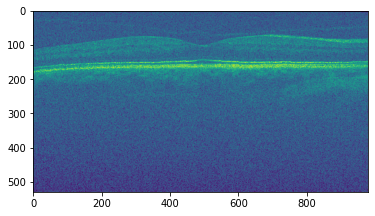

Tamaño de la imagen recortada:  (300, 900)


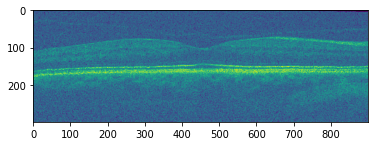

CLEAR_1: Imagen 1  recorte nº 7
CLEAR_2: Imagen 1  recorte nº 0
NOISE_1: Imagen 1  recorte nº 7
NOISE_2: Imagen 1  recorte nº 0
*******************************************************
Número de imagen  02
Tamaño de la imagen de original:  (508, 960)


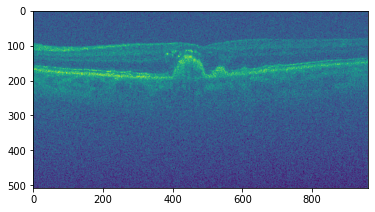

Tamaño de la imagen recortada:  (300, 900)


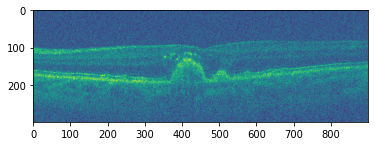

CLEAR_1: Imagen 2  recorte nº 14
CLEAR_2: Imagen 2  recorte nº 0
NOISE_1: Imagen 2  recorte nº 14
NOISE_2: Imagen 2  recorte nº 0
*******************************************************
Número de imagen  03
Tamaño de la imagen de original:  (550, 950)


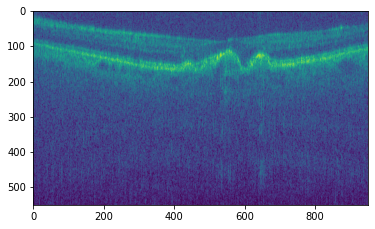

Tamaño de la imagen recortada:  (300, 900)


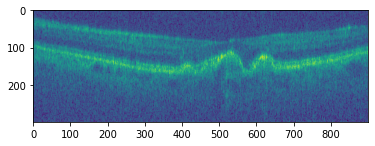

CLEAR_1: Imagen 3  recorte nº 21
CLEAR_2: Imagen 3  recorte nº 0
NOISE_1: Imagen 3  recorte nº 21
NOISE_2: Imagen 3  recorte nº 0
*******************************************************
Número de imagen  04
Tamaño de la imagen de original:  (530, 980)


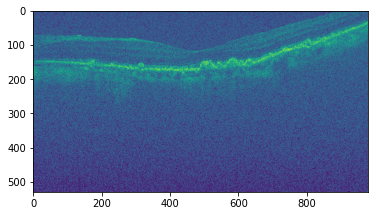

Tamaño de la imagen recortada:  (300, 900)


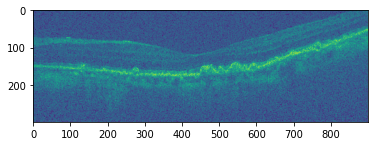

CLEAR_1: Imagen 4  recorte nº 28
CLEAR_2: Imagen 4  recorte nº 0
NOISE_1: Imagen 4  recorte nº 28
NOISE_2: Imagen 4  recorte nº 0
*******************************************************
Número de imagen  05
Tamaño de la imagen de original:  (540, 940)


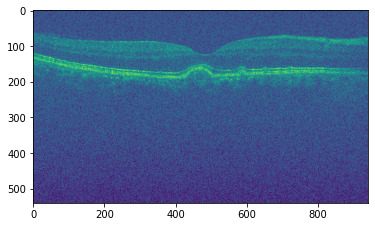

Tamaño de la imagen recortada:  (300, 900)


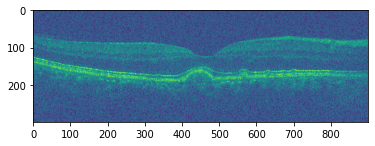

CLEAR_1: Imagen 5  recorte nº 35
CLEAR_2: Imagen 5  recorte nº 0
NOISE_1: Imagen 5  recorte nº 35
NOISE_2: Imagen 5  recorte nº 0
*******************************************************
Número de imagen  06
Tamaño de la imagen de original:  (510, 960)


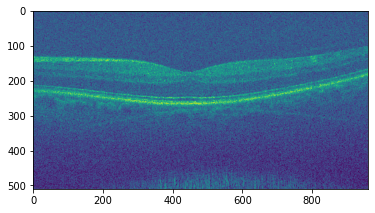

Tamaño de la imagen recortada:  (300, 900)


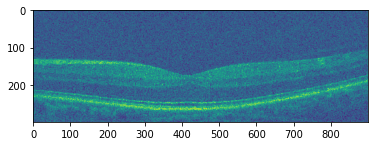

CLEAR_1: Imagen 6  recorte nº 42
CLEAR_2: Imagen 6  recorte nº 0
NOISE_1: Imagen 6  recorte nº 42
NOISE_2: Imagen 6  recorte nº 0
*******************************************************
Número de imagen  07
Tamaño de la imagen de original:  (550, 980)


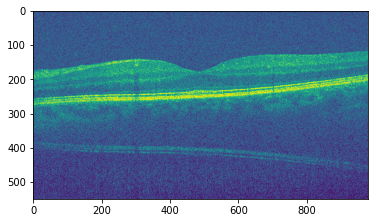

Tamaño de la imagen recortada:  (300, 900)


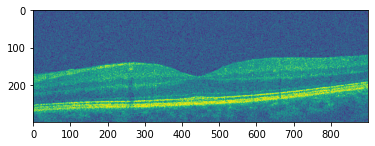

CLEAR_1: Imagen 7  recorte nº 49
CLEAR_2: Imagen 7  recorte nº 0
NOISE_1: Imagen 7  recorte nº 49
NOISE_2: Imagen 7  recorte nº 0
*******************************************************
Número de imagen  08
Tamaño de la imagen de original:  (550, 980)


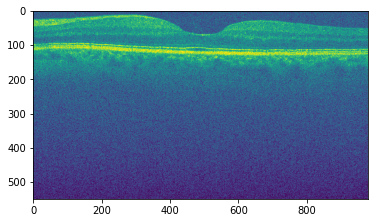

Tamaño de la imagen recortada:  (300, 900)


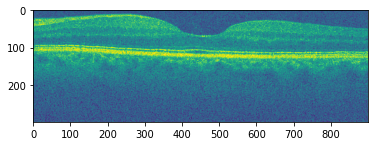

CLEAR_1: Imagen 8  recorte nº 56
CLEAR_2: Imagen 8  recorte nº 0
NOISE_1: Imagen 8  recorte nº 56
NOISE_2: Imagen 8  recorte nº 0
*******************************************************
Número de imagen  09
Tamaño de la imagen de original:  (540, 950)


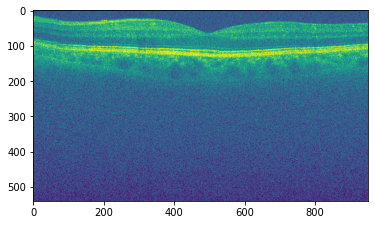

Tamaño de la imagen recortada:  (300, 900)


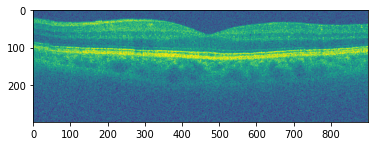

CLEAR_1: Imagen 9  recorte nº 63
CLEAR_2: Imagen 9  recorte nº 0
NOISE_1: Imagen 9  recorte nº 63
NOISE_2: Imagen 9  recorte nº 0
*******************************************************
Número de imagen  10
Tamaño de la imagen de original:  (530, 960)


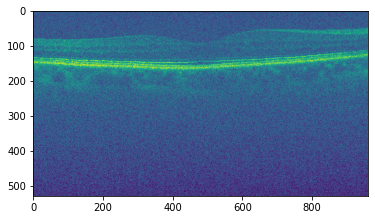

Tamaño de la imagen recortada:  (300, 900)


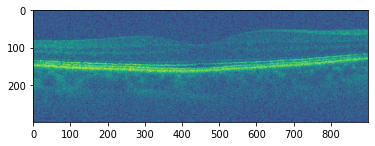

CLEAR_1: Imagen 10  recorte nº 70
CLEAR_2: Imagen 10  recorte nº 0
NOISE_1: Imagen 10  recorte nº 70
NOISE_2: Imagen 10  recorte nº 0
*******************************************************
Número de imagen  11
Tamaño de la imagen de original:  (450, 900)


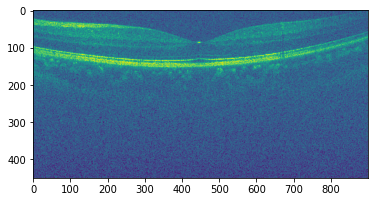

Tamaño de la imagen recortada:  (300, 900)


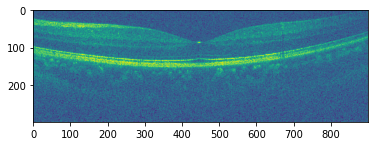

CLEAR_1: Imagen 11  recorte nº 77
CLEAR_2: Imagen 11  recorte nº 0
NOISE_1: Imagen 11  recorte nº 77
NOISE_2: Imagen 11  recorte nº 0
*******************************************************
Número de imagen  12
Tamaño de la imagen de original:  (450, 900)


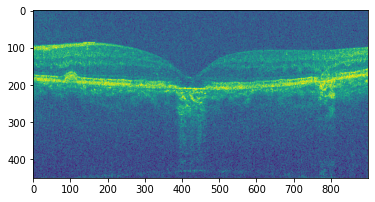

Tamaño de la imagen recortada:  (300, 900)


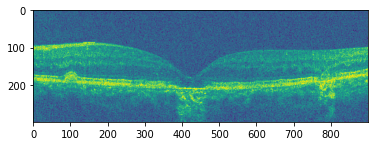

CLEAR_1: Imagen 12  recorte nº 84
CLEAR_2: Imagen 12  recorte nº 0
NOISE_1: Imagen 12  recorte nº 84
NOISE_2: Imagen 12  recorte nº 0
*******************************************************
Número de imagen  13
Tamaño de la imagen de original:  (450, 900)


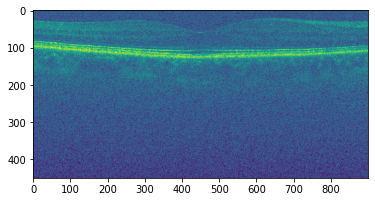

Tamaño de la imagen recortada:  (300, 900)


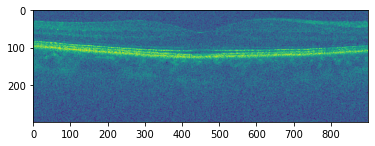

CLEAR_1: Imagen 13  recorte nº 91
CLEAR_2: Imagen 13  recorte nº 0
NOISE_1: Imagen 13  recorte nº 91
NOISE_2: Imagen 13  recorte nº 0
*******************************************************
Número de imagen  14
Tamaño de la imagen de original:  (450, 900)


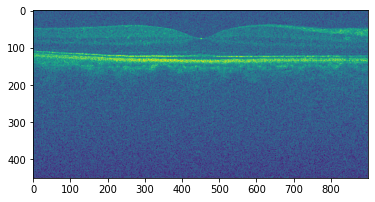

Tamaño de la imagen recortada:  (300, 900)


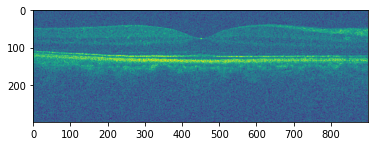

CLEAR_1: Imagen 14  recorte nº 98
CLEAR_2: Imagen 14  recorte nº 0
NOISE_1: Imagen 14  recorte nº 98
NOISE_2: Imagen 14  recorte nº 0
*******************************************************
Número de imagen  15
Tamaño de la imagen de original:  (450, 900)


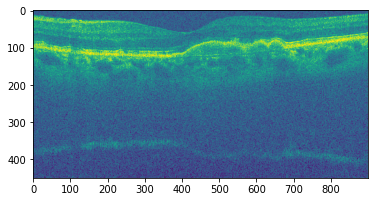

Tamaño de la imagen recortada:  (300, 900)


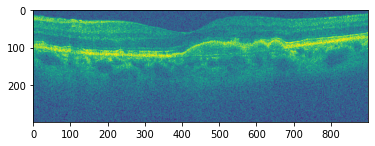

CLEAR_1: Imagen 15  recorte nº 98
CLEAR_2: Imagen 15  recorte nº 7
NOISE_1: Imagen 15  recorte nº 98
NOISE_2: Imagen 15  recorte nº 7
*******************************************************
Número de imagen  16
Tamaño de la imagen de original:  (450, 900)


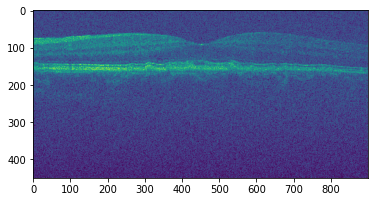

Tamaño de la imagen recortada:  (300, 900)


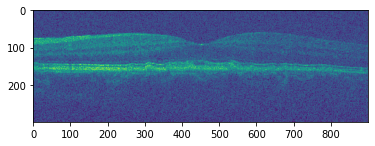

CLEAR_1: Imagen 16  recorte nº 98
CLEAR_2: Imagen 16  recorte nº 14
NOISE_1: Imagen 16  recorte nº 98
NOISE_2: Imagen 16  recorte nº 14
*******************************************************
Número de imagen  17
Tamaño de la imagen de original:  (450, 900)


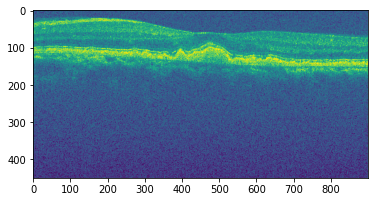

Tamaño de la imagen recortada:  (300, 900)


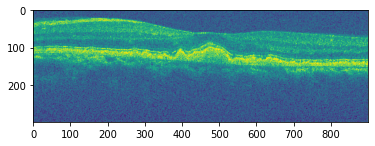

CLEAR_1: Imagen 17  recorte nº 98
CLEAR_2: Imagen 17  recorte nº 21
NOISE_1: Imagen 17  recorte nº 98
NOISE_2: Imagen 17  recorte nº 21
*******************************************************
clear_train (98, 300, 300)
noise_train (98, 300, 300)
clear_test (21, 300, 300)
noise_test (21, 300, 300)


In [ ]:
cont_noise_1 = 0
cont_noise_2 = 0
cont_clear_1 = 0
cont_clear_2 = 0

for i in range(0, N_images): # N_images = 34 
    
    clear_img = cv2.imread(clear_names[i], 0) # 0 = gray_scale (1 canal) >> Array de una dimensión
    noise_img = cv2.imread(noise_names[i], 0) # 0 = gray_scale (1 canal) >> Array de una dimensión

    # Obtenermos el número de la imagen de la ruta completa
    num_img = clear_names[i][54:56]
        
    print("Número de imagen ",num_img)
    
    # Visualizamos la imagen antes de recortar
    print("Tamaño de la imagen de original: ",noise_img.shape)
    plt.imshow(noise_img)
    plt.show()
    
    # Recortamos las imágenes a 300 x 900
    # Si la imagen es la 06, 07, 12, 24, 26 o 34 de train o las 01 de test  empezamos 50 pixeles más abajo en altura el recorte 
    # para que quede centrada la parte de la imagen con información (que no es negra)
   
    if (num_img == "06" or num_img == "07" or num_img == "12" or num_img == "24" or num_img == "26" or num_img == "34"):
        clear_img = get_cropped_img(clear_img, h_rec, w_rec, top_rec)
        noise_img = get_cropped_img(noise_img, h_rec, w_rec, top_rec)
    else:
        clear_img = get_cropped_img(clear_img, h_rec, w_rec, 0)
        noise_img = get_cropped_img(noise_img, h_rec, w_rec, 0)
    
    # Visualizamos la imagen recortada
    print("Tamaño de la imagen recortada: ",noise_img.shape)
    plt.imshow(noise_img)
    plt.show()
    
    # Cada imagen se atraviesa con una ventana deslizante de 300x300 pixeles 
    # con un paso de 50 píxeles 
    
    
    # IMÁGENES SIN RUIDO
    # Llamamos al método que hace el sliding window
    windows = sliding_window(clear_img, stride, (300, 300))
    # Recorremos los recortes que saca de cada imagen y los guardamos en un nparray
    for window in windows:
        # En window[2] se guarda el recorte
        h, w = window[2].shape
        # Solo se guardan los recortes de 300 x 300 en los arrays
        if (h == h_r and w == w_r):
            if (i<train_imgs):
                clear_array_train[cont_clear_1,:,:] = window[2]
                cont_clear_1+=1
            if (i>=train_imgs):
                clear_array_test[cont_clear_2,:,:] = window[2]
                cont_clear_2+=1

            # Mostrar la imagen guardada en el nparray
            # img = Image.fromarray(clear_arr[cont,:,:], 'L')
            # img.show()
    print("CLEAR_1: Imagen", i+1, " recorte nº",cont_clear_1)
    print("CLEAR_2: Imagen", i+1, " recorte nº",cont_clear_2)
    

    # IMÁGENES CON RUIDO
    # Llamamos al método que hace el sliding window
    windows = sliding_window(noise_img, stride, (300, 300))
    # Recorremos los recortes que saca de cada imagen y los guardamos en un nparray
    for window in windows:
        # En window[2] se guarda el recorte
        h, w = window[2].shape
        # Solo se guardan los recortes de 300 x 300 en los arrays
        if (h == h_r and w == w_r):
            if (i<train_imgs): 
                noise_array_train[cont_noise_1,:,:] = window[2]
                cont_noise_1+=1
            if (i>=train_imgs): 
                noise_array_test[cont_noise_2,:,:] = window[2]
                cont_noise_2+=1
            # Mostrar la imagen guardada en el nparray
            # img = Image.fromarray(noise_arr[cont,:,:], 'L')
            # img.show()

    print("NOISE_1: Imagen", i+1, " recorte nº",cont_noise_1)
    print("NOISE_2: Imagen", i+1, " recorte nº",cont_noise_2)

    print("*******************************************************")

clear_array_train = clear_array_train[0:cont_clear_1, :, :]
noise_array_train = noise_array_train[0:cont_noise_1, :, :]
clear_array_test = clear_array_test[0:cont_clear_2, :, :]
noise_array_test = noise_array_test[0:cont_noise_2, :, :]
print("clear_train",clear_array_train.shape)
print("noise_train",noise_array_train.shape)
print("clear_test",clear_array_test.shape)
print("noise_test",noise_array_test.shape)



In [ ]:
img_comp = Image.new('RGB', (600, 300), color = (255,255,255))

for id in range(0, clear_array_train.shape[0]): 
    noise_patch = noise_array_train[id, :,:]
    clear_patch = clear_array_train[id, :,:]
    noise_img = Image.fromarray(noise_patch) 
    clear_img = Image.fromarray(clear_patch) 
    img_comp.paste(noise_img, (300, 0))
    img_comp.paste(clear_img, (0, 0))
    # plt.imshow(img_comp)
    # plt.show()
    filepath = BASE_FOLDER+'datasets/images_pix2pix/train/%0.3d.jpg' % (id+1)
    img_comp.save(filepath)

for id in range(0, clear_array_test.shape[0]): 
    noise_patch = noise_array_test[id, :,:]
    clear_patch = clear_array_test[id, :,:]
    noise_img = Image.fromarray(noise_patch) 
    clear_img = Image.fromarray(clear_patch)
    img_comp.paste(noise_img, (300, 0))
    img_comp.paste(clear_img, (0, 0))


    # plt.imshow(img_comp)
    # plt.show()
    filepath = BASE_FOLDER+'datasets/images_pix2pix/test/%0.3d.jpg' % (id+1)
    img_comp.save(filepath)
